In [1]:
##### -*-coding:utf-8 -*-
# import all the libraries 
# python==3.9.13; jupyterlab==3.0.12; matplotlib==3.3.4; pwlf ==2.2.1
# npTDMS==1.1.0; numpy==1.20.1; opencv-python==4.5.1.48; pandas==1.2.3; scipy==1.6.1; tifffile==2021.3.5
from __future__ import division
import os
from sympy import *
from sympy import coth
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from nptdms import TdmsFile
import pwlf
import sys
%matplotlib widget
# %matplotlib inline
print(sys.executable)

/Users/longfu/opt/anaconda3/envs/normal-python/bin/python


In [4]:
# read raw .tdms file with TdmsFile function
filename = input('please type in the file name with absolute path:' )
tdms_file = TdmsFile(filename)

# please write down the starting and the ending time of ROI (pol events)

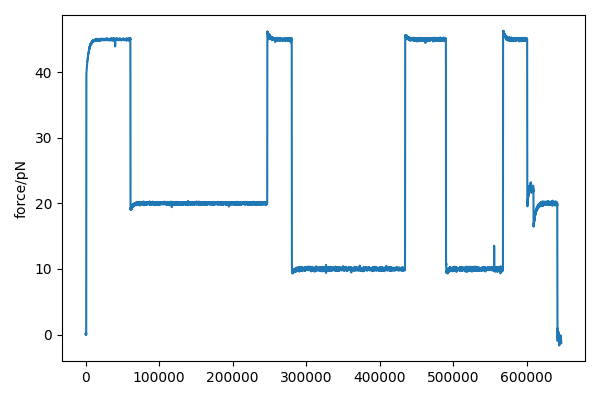

In [6]:
# run this step to find out the Time of ROI
time = tdms_file['FD Data']['Time (ms)'][:]
time = np.array(time)
force = tdms_file['FD Data']['Force Channel 0 (pN)'][:]
force = np.array(force)
distance = tdms_file['FD Data']['Distance 1 (um)'][:]
distance = np.array(distance)

# run this step to find out the Time of ROI
plt.figure(figsize=(6,4))
plt.plot(time,force)
# plt.plot(time,distance)
# plt.plot(distance,force)
plt.ylabel('force/pN')
plt.tight_layout()
plt.show()

In [85]:
# please enter cycle number of interest
cycle = input('please type in cycle number of interest(e.g.:01):')

time_from_pol = float(input('please type in the starting time of pol in ms:'))
time_to_pol = float(input('please type in the ending time of pol in ms:'))


In [86]:
# here you will select and analyze your interesting cycle with corresponding time range; 
# define a temporary index to compute time of ROI, and subsuquent ROI of force, distance

indtemp_pol = np.where((time <= time_to_pol) & (time >= time_from_pol))

# pol time range of ROI
time_range_pol = time[indtemp_pol]
force_range_pol = force[indtemp_pol]
distance_range_pol = distance[indtemp_pol]

In [87]:
# parameters for tWLC model: Peter Gross, et al. Nature Physics volume 7, pages731–736(2011)
# dsDNA contour length Lc = 2.85056um; persistent length Lp = 56nm
# the twist rigidity C=440 pN nm2;
# the stretching modulus S=1500 pN;
# the twist–stretch coupling g(F) is given by: g(F) =g0+g1F,where g0=−637 pN nm, g1=17 nm
EEDds,Lc,F,Lp,C,g0,g1,S = symbols('EEDds Lc F Lp C g0 g1 S', real=True)
C = 440
g0= -637
g1 = 17
Lc = 2.85056
Lp = 56
S = 1500
# tWLC model expression:
def tWLC(F):
    EEDds = Lc*(1-0.5*(4.1/(F*Lp))**0.5 + C*F/(-(g0+g1*F)**2 + S*C))
    return (EEDds)

# parameters for FJC model: Smith, S. B., et al. Science 271, 795–799 (1996).
# ssDNA contour length Lss = 4.69504um,
# Kuhn length b = 1.5nm (persistent length is 0.75nm),
# the stretching modulus S=800pN
EEDss,Lss,b,Sss = symbols('EEDss Lss b Sss', real=True)
Lss = 4.69504
b = 1.5
Sss = 800
# FJC model expression:
def FJC(F):
    EEDss = []
    for Fext in F:
        x  = Lss * (coth(Fext * b / 4.1) - 4.1 / (Fext * b)) * (1 + Fext / Sss)
        EEDss.append(x)
    EEDss = np.array(EEDss)
    return (EEDss)

# EEDss,Lss,b,Sss,Fext = symbols('EEDss Lss b Sss Fext', real=True)
# Lss = 4.69504
# b = 1.5
# Sss = 800
# # FJC model expression:
# def FJC(Fext):
#     EEDss  = Lss * (coth(Fext * b / 4.1) - 4.1 / (Fext * b)) * (1 + Fext / Sss)
#     return (EEDss)

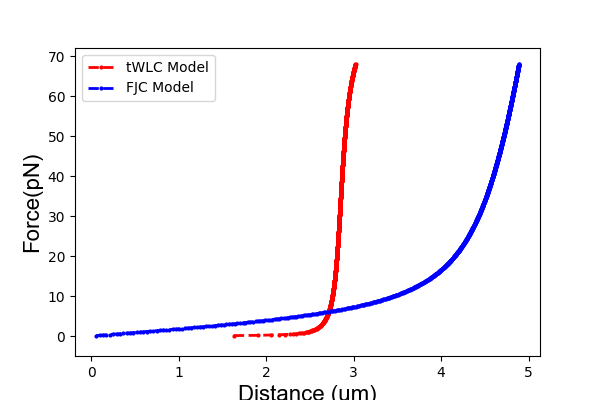

In [88]:
Force = np.linspace(0.1,68,1000)

plt.figure(figsize=(6,4))
font = {'family': 'Arial', 'weight': 'normal', 'size': 16}


plt.xlabel('Distance (um)',fontdict=font)
plt.ylabel('Force(pN)',fontdict=font)
plt.plot(tWLC(Force),Force,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='tWLC Model')
plt.plot(FJC(Force),Force,color='b', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='FJC Model')

plt.legend()
# plt.title('Experimental Data fit to tWLC and FJC Model',fontdict=font)
plt.ylim(-5,72)

plt.show()
plt.tight_layout()

# you can only see experimental data after you run the next code block 

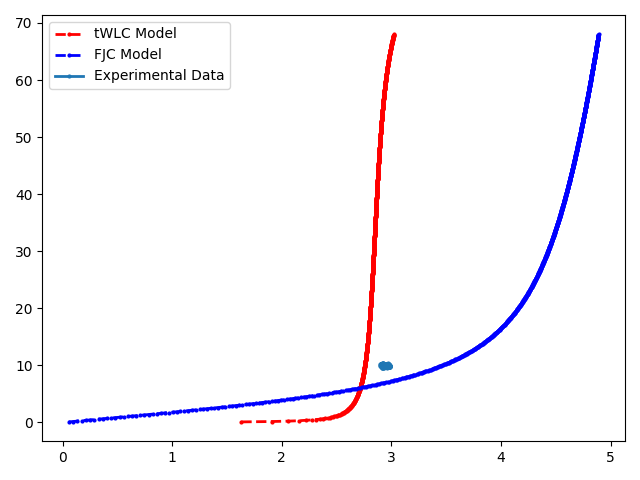

In [89]:
# Default bead size = 1.76um
bead_size = 1.76

plt.figure()
plt.plot(tWLC(Force),Force,color='red', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='tWLC Model')
plt.plot(FJC(Force),Force,color='b', marker='o', linestyle='dashed',linewidth=2, markersize=2,label='FJC Model')
# plot experimental data together with 
plt.plot(distance_range_pol - bead_size, force_range_pol, marker='o', linestyle='solid',linewidth=2, markersize=2,label='Experimental Data')
plt.legend()
plt.tight_layout()
plt.show()
    
# plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-DataFit2Model'+'.eps', dpi=300)

End-to-end distance between two optically trapped beads consists ssDNA fraction and dsDNA fraction. By calculating:
- *ssDNA percentage* : ssDNA % =(𝐸𝐸𝐷 −𝑡𝑊𝐿𝐶(𝐹))/(𝐹𝐽𝐶(𝐹) -SSB_factor(F)−𝑡𝑊𝐿𝐶(𝐹))
- *dsDNA percentage* : dsDNA % =1-ssDNA % , 
- *ssDNA/dsDNA junction position* could be obtained following: Junction position =(𝑠𝑠% ∗𝐹𝐽𝐶(𝐹))/(𝑠𝑠% ∗𝐹𝐽𝐶(𝐹)+𝑑𝑠% ∗𝑒𝑊𝐿𝐶(𝐹) ) * EED). 
- the SSB_factor(F) defines the shortening distance by the SSB binding

Junction position changes is then plotted as a function of time.

In [90]:
# Default exo_force is 50pN and pol_force 20pN 
exo_force = 50
pol_force = 10

SSB_factor = 0.03 #10pN; note this value is an estimate to calibrate the effect of SSB binding
# SSB_factor = 0.02 #20pN; note this value is an estimate to calibrate the effect of SSB binding 
# SSB_factor = 0 # 50pN;  note this value is an estimate to calibrate the effect of SSB binding

# calculating the length of dsDNA under exo and pol force
dsDNA_exo_ref = tWLC(exo_force)
dsDNA_pol_ref = tWLC(pol_force)

# calculating the length of ssDNA under exo and pol force
ssDNA_exo_ref = 4.69504 * (coth(exo_force * 1.5 / 4.1) - 4.1 / (exo_force * b)) * (1 + exo_force / 800)
ssDNA_pol_ref =4.69504 * (coth(pol_force * 1.5 / 4.1) - 4.1 / (pol_force * b)) * (1 + pol_force / 800)

In [91]:
# calculating ssDNA under exo and pol force
ssDNA_pol_percentage = (distance_range_pol - bead_size - dsDNA_pol_ref)/(ssDNA_pol_ref - SSB_factor - dsDNA_pol_ref)

# calculating basepairs: Construct of pkyb1 DNA has a length of 8393bp
basepairs = (1-ssDNA_pol_percentage) * 8393

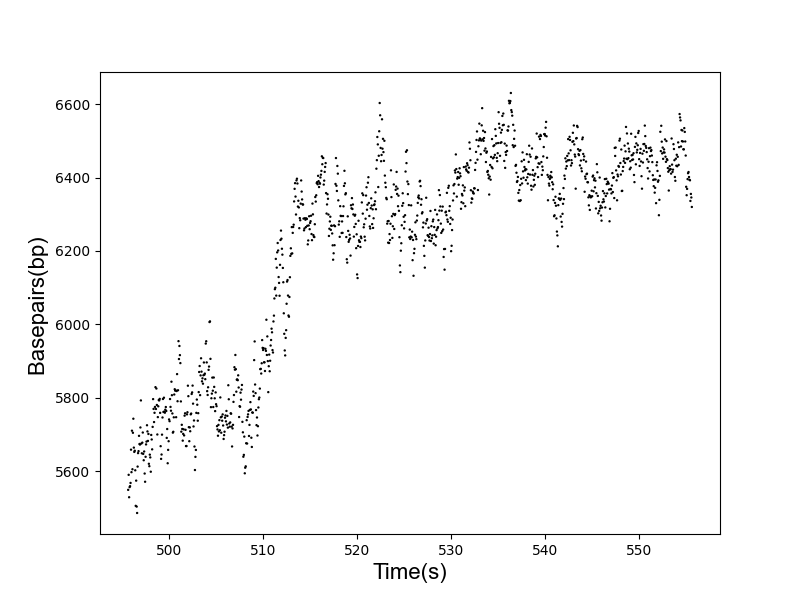

In [92]:
# plot ssDNA% as a function of time, only in the rang of pol events
plt.figure(figsize=(8,6))

plt.ylabel('Basepairs(bp) ',fontdict=font)
plt.xlabel('Time(s)',fontdict=font)
plt.scatter(time_range_pol/1000,(1-ssDNA_pol_percentage)  * 8393,color='black', linestyle='dashed',s=0.5,label='End-to-End Distance')
# plt.ylim(0,1500)

# plt.xlim(8.5,158)
plt.show()
plt.tight_layout()

# plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '-ssDNA_percentage'+'.png', dpi=300)

In [93]:
excel_filename = filename.replace('.tdms', '-cycle#') + cycle +'_rawData'+'.xlsx'

writer = pd.ExcelWriter(excel_filename)
data_raw = {'time_pol':time_range_pol/1000,
        'basepairs_pol':(1-ssDNA_pol_percentage)  * 8393,
        'force_pol':force_range_pol}
df_1 = pd.DataFrame(data_raw)
df_1.to_excel(writer)
writer.save()

/var/folders/7s/4zb5dg7n24q8rnf1200rm98r0000gn/T/ipykernel_1991/3000476079.py:9: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [94]:
# By observing the above Basepairs-Time traces, we define a segment number to fit.
segment_number = int(input('please type in segment number that you want to fit:'))

In [95]:
# Let's move on to find change-points
data =  pd.read_excel(excel_filename)
x = data['time_pol']
y = data['basepairs_pol']

# initialize piecewise linear fit with your x and y data
my_pwlf = pwlf.PiecewiseLinFit(x, y)
break_point = my_pwlf.fit(segment_number)

# predict for the determined points
xHat = np.linspace(min(x), max(x), num=10000)
yHat = my_pwlf.predict(xHat)
#get event number
event_number = np.arange(1,my_pwlf.n_segments+1)
# Get the slopes
my_slopes = my_pwlf.slopes
# Get the model parameters
beta = my_pwlf.beta
# calculate the standard errors associated with each beta parameter
se = my_pwlf.standard_errors()

# calculate the piecewise R^2 value
R2values = np.zeros(my_pwlf.n_segments)
event_duration = np.zeros(my_pwlf.n_segments)
fragment_length = np.zeros(my_pwlf.n_segments)
event_ssr = np.zeros(my_pwlf.n_segments)
event_sst = np.zeros(my_pwlf.n_segments)
for i in range(my_pwlf.n_segments):
    # segregate the data based on break point locations
    xmin = my_pwlf.fit_breaks[i]
    xmax = my_pwlf.fit_breaks[i+1]
    xtemp = my_pwlf.x_data
    ytemp = my_pwlf.y_data
    indtemp = np.where(xtemp >= xmin)
    xtemp = my_pwlf.x_data[indtemp]
    ytemp = my_pwlf.y_data[indtemp]
    indtemp = np.where(xtemp <= xmax)
    xtemp = xtemp[indtemp]
    ytemp = ytemp[indtemp]
    duration = xtemp[-1] - xtemp[0]
    length = ytemp[-1] - ytemp[0]

    # predict for the new data
    yhattemp = my_pwlf.predict(xtemp)
    # calcualte ssr
    e = yhattemp - ytemp
    ssr = np.dot(e, e)
    # calculate sst
    ybar = np.ones(ytemp.size) * np.mean(ytemp)
    ydiff = ytemp - ybar
    sst = np.dot(ydiff, ydiff)
    R2values[i] = 1.0 - (ssr/sst)
    event_duration[i] = duration
    fragment_length[i] = length
    event_ssr[i] = ssr
    event_sst[i] = sst

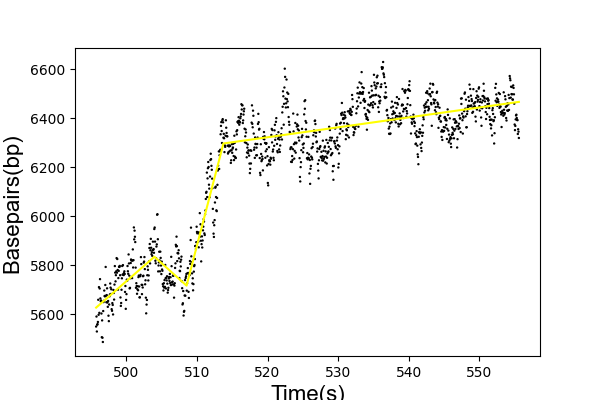

In [96]:
# plot step-fitted data
plt.figure(figsize=(6,4))

plt.ylabel('Basepairs(bp) ',fontdict=font)
plt.xlabel('Time(s)',fontdict=font)
plt.scatter(time_range_pol/1000,(1-ssDNA_pol_percentage)  * 8393,color='black', linestyle='dashed',s=0.5,label='End-to-End Distance')
plt.plot(xHat, yHat, '-',color='yellow')

# plt.ylim(0,1500)
# plt.xlim(8.5,158)

plt.show()
plt.tight_layout()

plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '_Step_fitted'+'.png', dpi=300)

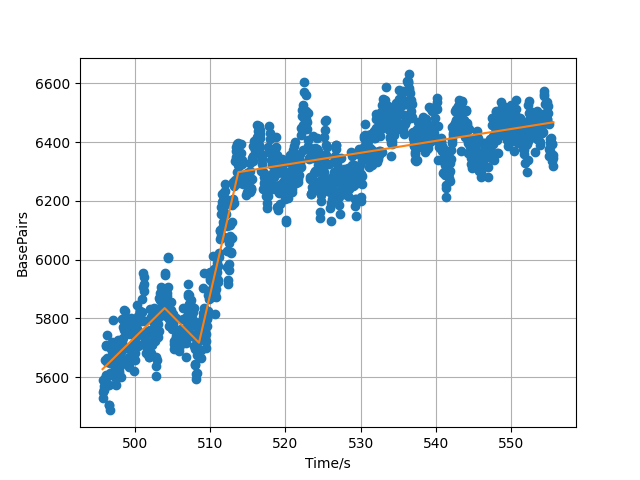

In [97]:
#plot step-fitted data (this is optional)
plt.figure()
plt.plot(x, y, 'o')
plt.plot(xHat, yHat, '-')
plt.grid()
plt.xlabel('Time/s')
plt.ylabel('BasePairs')
plt.show()
plt.tight_layout()

plt.savefig(filename.replace('.tdms', '-cycle#') + cycle + '_Step_fitted2'+'.png', dpi=300)

In [98]:
excel_filename = filename.replace('.tdms', '-cycle#') + cycle +'_StepDetectedData'+'.xlsx'

writer = pd.ExcelWriter(excel_filename)
data_StepFinding = {'event_number': event_number,
        'rate(um/s)':my_slopes,
        'duration(s)':event_duration,
        'fragment_length(um)':fragment_length,
        'SSR':event_ssr,
        'SST':event_sst,
        'R2values':R2values,
        'standard errors':se[:-1],
        'break_point':break_point[:-1]}
df_1 = pd.DataFrame(data_StepFinding)
df_1.to_excel(writer,sheet_name ='data_StepFinding')
writer.save()

/var/folders/7s/4zb5dg7n24q8rnf1200rm98r0000gn/T/ipykernel_1991/1341772512.py:15: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
